Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

class DataPreprocessor:
    def __init__(self, data):
        self.data = data

    def feature_engineering(self):
        # Loan-to-Income Ratio
        self.data['loan_amount_to_income_ratio'] = self.data['loan_amnt'] / self.data['annual_inc']

        # Balance-to-Loan Ratio
        self.data['balance_to_loan_ratio'] = self.data['account_bal'] / self.data['loan_amnt']

        # Categorize CIBIL score into risk tiers
        bins = [0, 600, 700, 800, 900]
        labels = ['Very Low', 'Low', 'Medium', 'High']
        self.data['cibil_risk_tier'] = pd.cut(self.data['cibil_score'], bins=bins, labels=labels, right=False)

    def handle_missing_values(self):
        numeric_cols = self.data.select_dtypes(include=np.number).columns
        categorical_cols = self.data.select_dtypes(exclude=np.number).columns

        # Fill numeric missing values with median
        self.data[numeric_cols] = self.data[numeric_cols].fillna(self.data[numeric_cols].median())

        # Fill categorical missing values with mode
        self.data[categorical_cols] = self.data[categorical_cols].fillna(self.data[categorical_cols].mode().iloc[0])

    def encode_categorical(self):
        categorical_cols = ['home_ownership', 'verification_status', 'purpose',
                            'application_type', 'sub_grade', 'term', 'cibil_risk_tier']

        for col in categorical_cols:
            if col in self.data.columns:
                self.data[col] = LabelEncoder().fit_transform(self.data[col])

    def outlier_detection(self):
        numeric_cols = self.data.select_dtypes(include=np.number).columns

        for col in numeric_cols:
            # Calculate IQR
            Q1 = self.data[col].quantile(0.25)
            Q3 = self.data[col].quantile(0.75)
            IQR = Q3 - Q1

            # Cap outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.data[col] = np.clip(self.data[col], lower_bound, upper_bound)

    def handle_class_imbalance(self, X, y):
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        return X_resampled, y_resampled

    def normalize_features(self, X):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled

# Usage
if __name__ == "__main__":
    # Load data
    data = pd.read_excel('train_data.xlsx')

    # Initialize preprocessor
    preprocessor = DataPreprocessor(data)

    # Preprocessing Steps
    preprocessor.feature_engineering()
    preprocessor.handle_missing_values()
    preprocessor.encode_categorical()
    preprocessor.outlier_detection()

    # Features and target
    X = data.drop(columns=['customer_id', 'transaction_date', 'loan_status'])
    y = data['loan_status']

    # Handle class imbalance
    X_resampled, y_resampled = preprocessor.handle_class_imbalance(X, y)

    # Normalize features
    X_normalized = preprocessor.normalize_features(X_resampled)

    print("Preprocessing complete!")


Preprocessing complete!


Logistic Regression:
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68     16996
           1       0.67      0.71      0.69     16611

    accuracy                           0.69     33607
   macro avg       0.69      0.69      0.69     33607
weighted avg       0.69      0.69      0.69     33607


Confusion Matrix:
[[11315  5681]
 [ 4896 11715]]


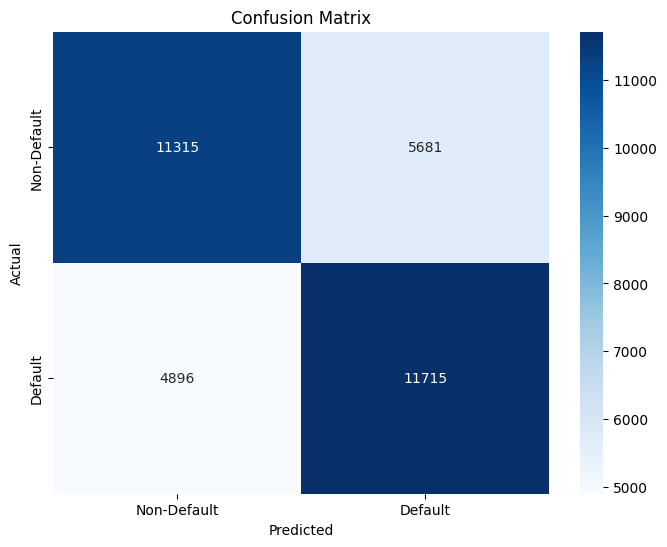


Random Forest:
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81     16996
           1       0.80      0.81      0.81     16611

    accuracy                           0.81     33607
   macro avg       0.81      0.81      0.81     33607
weighted avg       0.81      0.81      0.81     33607


Confusion Matrix:
[[13621  3375]
 [ 3109 13502]]


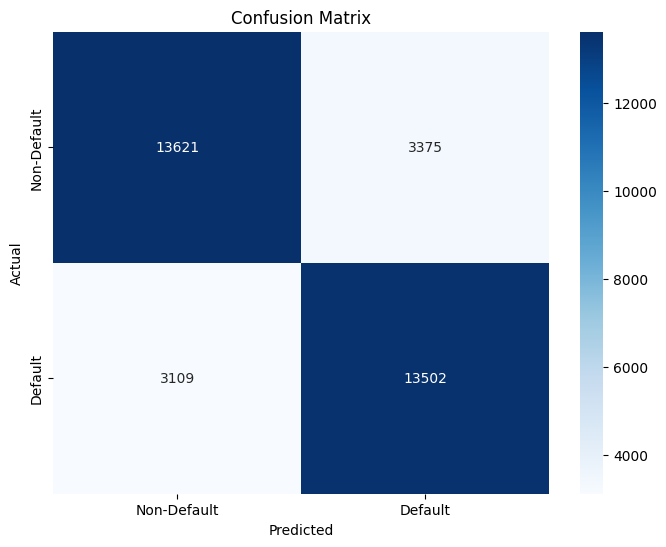

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class LoanDefaultModel:
    def __init__(self, model_type='logistic'):
        if model_type == 'logistic':
            self.model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
        elif model_type == 'random_forest':
            self.model = RandomForestClassifier(random_state=42, class_weight='balanced')
        else:
            raise ValueError("Unsupported model type. Use 'logistic' or 'random_forest'.")

    def split_data(self, X, y, test_size=0.2):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_test)

        # Classification Report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        print("\nConfusion Matrix:")
        print(cm)

        # Visualize Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default']
        )
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

# Usage
if __name__ == "__main__":
    # Initialize preprocessor and preprocess data
    data = pd.read_excel('train_data.xlsx')
    preprocessor = DataPreprocessor(data)

    # Preprocessing pipeline
    preprocessor.feature_engineering()
    preprocessor.handle_missing_values()
    preprocessor.encode_categorical()
    preprocessor.outlier_detection()

    # Extract features and target
    X = data.drop(columns=['customer_id', 'transaction_date', 'loan_status'])
    y = data['loan_status']

    # Handle class imbalance
    X_resampled, y_resampled = preprocessor.handle_class_imbalance(X, y)

    # Normalize features
    X_normalized = preprocessor.normalize_features(X_resampled)

    # Train and evaluate Logistic Regression model
    print("Logistic Regression:")
    logistic_model = LoanDefaultModel(model_type='logistic')
    logistic_model.split_data(X_normalized, y_resampled)
    logistic_model.train_model()
    logistic_model.evaluate_model()

    # Train and evaluate Random Forest model
    print("\nRandom Forest:")
    rf_model = LoanDefaultModel(model_type='random_forest')
    rf_model.split_data(X_normalized, y_resampled)
    rf_model.train_model()
    rf_model.evaluate_model()


**Random Forest outperforms Logistic Regression across all key metrics: accuracy, precision, recall, and F1-score.
Random Forest is a more robust model for this task, and it is the better choice for predicting loan defaults in this case.**

Logistic Regression:
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68     16996
           1       0.67      0.70      0.69     16611

    accuracy                           0.69     33607
   macro avg       0.69      0.69      0.69     33607
weighted avg       0.69      0.69      0.69     33607


Confusion Matrix:
[[11322  5674]
 [ 4903 11708]]


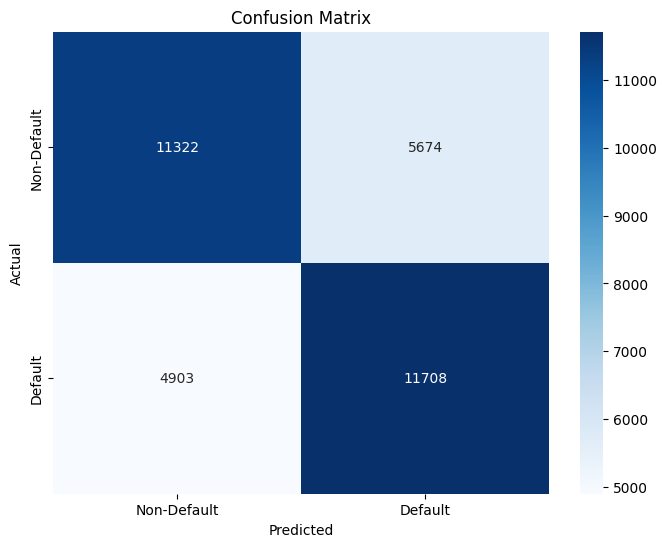


Random Forest:


In [ ]:
from sklearn.model_selection import GridSearchCV

class LoanDefaultModel:
    def __init__(self, model_type='logistic'):
        if model_type == 'logistic':
            self.model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
        elif model_type == 'random_forest':
            self.model = RandomForestClassifier(random_state=42, class_weight='balanced')
        else:
            raise ValueError("Unsupported model type. Use 'logistic' or 'random_forest'.")

    def split_data(self, X, y, test_size=0.2):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)

    def tune_model(self, param_grid):
        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)
        print("Best Parameters:", grid_search.best_params_)
        self.model = grid_search.best_estimator_

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_test)

        # Classification Report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        print("\nConfusion Matrix:")
        print(cm)

        # Visualize Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default']
        )
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

# Usage
if __name__ == "__main__":
    # Initialize preprocessor and preprocess data
    data = pd.read_excel('train_data.xlsx')
    preprocessor = DataPreprocessor(data)

    # Preprocessing pipeline
    preprocessor.feature_engineering()
    preprocessor.handle_missing_values()
    preprocessor.encode_categorical()
    preprocessor.outlier_detection()

    # Extract features and target
    X = data.drop(columns=['customer_id', 'transaction_date', 'loan_status'])
    y = data['loan_status']

    # Handle class imbalance
    X_resampled, y_resampled = preprocessor.handle_class_imbalance(X, y)

    # Normalize features
    X_normalized = preprocessor.normalize_features(X_resampled)

    # Train and evaluate Logistic Regression model with hyperparameter tuning
    print("Logistic Regression:")
    logistic_model = LoanDefaultModel(model_type='logistic')
    logistic_model.split_data(X_normalized, y_resampled)

    # Define hyperparameter grid for Logistic Regression
    logistic_param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
        'penalty': ['l2'],  # Penalty type
        'solver': ['liblinear', 'saga']  # Solver to use
    }
    logistic_model.tune_model(logistic_param_grid)
    logistic_model.evaluate_model()

    # Train and evaluate Random Forest model with hyperparameter tuning
    print("\nRandom Forest:")
    rf_model = LoanDefaultModel(model_type='random_forest')
    rf_model.split_data(X_normalized, y_resampled)

    # Define hyperparameter grid for Random Forest
    rf_param_grid = {
        'n_estimators': [50, 100, 200],  # Number of trees in the forest
        'max_depth': [10, 20, None],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
        'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
        'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
    }
    rf_model.tune_model(rf_param_grid)
    rf_model.evaluate_model()


In [ ]:
# Save the Random Forest model
    rf_model.save_model('random_forest_model.pkl')